In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [4]:
%load_ext autoreload
%autoreload 2

In [180]:
from mc_plot_utils import MCMCResult

In [21]:
import mc_plot_utils

In [17]:
surp.set_yields()

In [18]:
df = pd.read_csv("yield_fits.tsv", sep=r"\s+", comment="#")
df

,model,y0,zeta0,zeta0_err,zeta1,zeta1_err
0,fruity,3.110,3.7,0.3,-3.5,0.3
1,aton,-0.009,1.0,1.9,-10.0,3.0
2,monash,2.960,2.3,0.5,-11.0,1.0
3,nugrid,9.250,8.1,1.9,-4.6,1.7
4,fruity_mf0.5,2.830,3.3,0.2,-1.8,0.2
5,fruity_mf0.7,3.600,4.2,0.3,-3.1,0.3
6,fruity_mf1.5,3.110,3.4,0.2,-3.0,0.2


In [19]:
vice.yields.agb.settings["c"] = surp.agb_interpolator.interpolator("c", mass_factor=0.7)
surp.yields.calc_y(surp.Z_SUN, kind="agb") * 1e3

0.3604729682654721

In [56]:
yagb_props = {}

for _, row in df.iterrows():
    yagb_props[row.model] = {
        "y0": row.y0 * 1e-4,
        "y_a": row.zeta0 * 0e-4,
        "zeta_a": row.zeta1 * 0e-4,
    }

yagb_props["analytic"] = {
    "y0": 1e-3,
    "y_a": 1e-3,
    "zeta_a": 1e-3
}

yagb_props

{'fruity': {'y0': 0.000311, 'y_a': 0.0, 'zeta_a': -0.0},
 'aton': {'y0': -9e-07, 'y_a': 0.0, 'zeta_a': -0.0},
 'monash': {'y0': 0.000296, 'y_a': 0.0, 'zeta_a': -0.0},
 'nugrid': {'y0': 0.000925, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf0.5': {'y0': 0.000283, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf0.7': {'y0': 0.00036, 'y_a': 0.0, 'zeta_a': -0.0},
 'fruity_mf1.5': {'y0': 0.000311, 'y_a': 0.0, 'zeta_a': -0.0},
 'analytic': {'y0': 0.001, 'y_a': 0.001, 'zeta_a': 0.001}}

In [136]:
def calc_χ2(result, median=False, normalized=False, verbose=False, generous=False):

    if median:
        samples = result.samples.median()
    else:
        samples = result.samples
        
    chi2_ah = calc_χ2_binned(result.ah, samples, result.labels, generous=generous)
    chi2_afe = calc_χ2_binned(result.afe, samples, result.labels, generous=generous)

    df = (len(result.ah) + len(result.afe)) - len(result.labels)


    if verbose:
        print("df", df)
        print("ah", chi2_ah)
        print("afe", chi2_afe)
        
    if normalized:
        return (chi2_ah + chi2_afe) / df
    else:

        return (chi2_ah + chi2_afe) 


In [196]:
def load_model(filename, props, test=False, burn=0, **kwargs):
    y0 = props["y0"],
    y_a = props["y_a"]
    zeta_a = props["zeta_a"]
    
    if test:
        result = MCMCResult.from_test_file(filename, burn=burn)
    else:
        result = MCMCResult.from_file("../models/mcmc_models_2d/" + filename + "/", y0=y0, burn=burn, y_a=y_a, zeta_a=zeta_a, **kwargs)
    return result

In [137]:
def calc_χ2_binned(binned_data, samples, labels, generous = True):

    y_exp = binned_data.obs
    sigma2_exp = binned_data.obs_err**2 / (binned_data.obs_counts)

    χ2 = 0
    for i in range(len(y_exp)):
        y_tot = np.sum([binned_data[label][i] * samples[label] for label in labels], axis=0)
        sigma2_err = np.sum([binned_data[f"{label}_err"][i]**2 * samples[label] / binned_data["_counts"][i] for label in labels], axis=0)

        if generous:
            sigma_int = np.median(samples.sigma_int)
        else:
            sigma_int = 0
            
        χ2 += (y_exp[i] - y_tot)**2  / (sigma2_exp[i] + sigma2_err + sigma_int ** 2)
    
    return  χ2
    

In [138]:
calc_χ2(results["fiducial"], median=True)

np.float64(314.5979498050405)

df 27
ah 195.49020881405727
afe 119.10774099098326
fiducial
fiducial 	 -505.82011243841043 	 11.651775918705205

df 27
ah 536.5056755701523
afe 338.0097823924222
fiducial_sigma
fiducial_sigma 	 -51.48903664442319 	 32.38946140602128

df 27
ah 195.49020881405727
afe 119.10774099098326
fruity
fruity 	 -505.82011243841043 	 11.651775918705205

df 27
ah 536.5056755701523
afe 338.0097823924222
fruity_sigma
fruity_sigma 	 -51.48903664442319 	 32.38946140602128

df 27
ah 739.2997841135052
afe 257.4652433554755
fruity_m0.7_sigma
fruity_m0.7_sigma 	 -47.07409098799489 	 36.91722323959188

df 27
ah 206.37110241309273
afe 330.66882589137504
aton_sigma
aton_sigma 	 -56.29721730855321 	 19.89036771498029

df 27
ah 97.04531228311016
afe 236.86773716947562
aton
aton 	 -493.8114421138058 	 12.367149979725399

df 27
ah 224.6349869538157
afe 234.33516869704727
monash
monash 	 -765.5834592200451 	 16.998894653735665

df 27
ah 332.1045528900871
afe 353.87028953480154
monash_sigma
monash_sigma 	 -62.271300

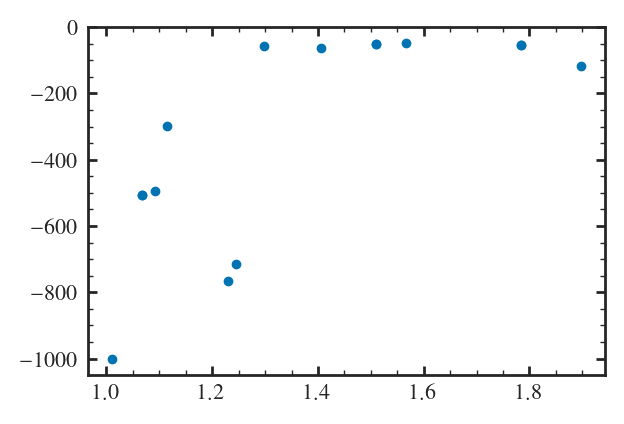

In [139]:

chi2s = []
lps = []
for label, result in results.items():
    χ2 = calc_χ2(result, median=True, normalized=True, verbose=True)
    lp = np.quantile(result.samples.lp, 0.2)
    chi2s.append(χ2)
    lps.append(lp)
    if lp < 0:
        print(label)
    print(label, "\t", lp, "\t", χ2)
    print()

plt.scatter(np.log10(chi2s), np.array(lps))


fiducial           11.65    11.70 -    0.22 +    0.24
fiducial_sigma     32.39    36.20 -   10.58 +   14.33
fruity             11.65    11.70 -    0.22 +    0.24
fruity_sigma       32.39    36.20 -   10.58 +   14.33
fruity_m0.7_sigma   36.92    40.99 -   12.30 +   15.69
aton_sigma         19.89    22.56 -    6.10 +   10.96
aton               12.37    12.41 -    0.28 +    0.34
monash             17.00    17.03 -    0.31 +    0.37
monash_sigma       25.41    28.15 -    6.48 +   10.97
nugrid             17.58    17.62 -    0.12 +    0.17
nugrid_sigma0.05   60.74    65.20 -   18.42 +   23.13
nugrid_sigma       60.74    65.20 -   18.42 +   23.13
fiducial_constrained_sigma   79.05    81.36 -   22.04 +   27.29
fiducial_constrained   10.23    10.25 -    0.48 +    0.56
fruity_m0.7        13.02    13.06 -    0.45 +    0.51


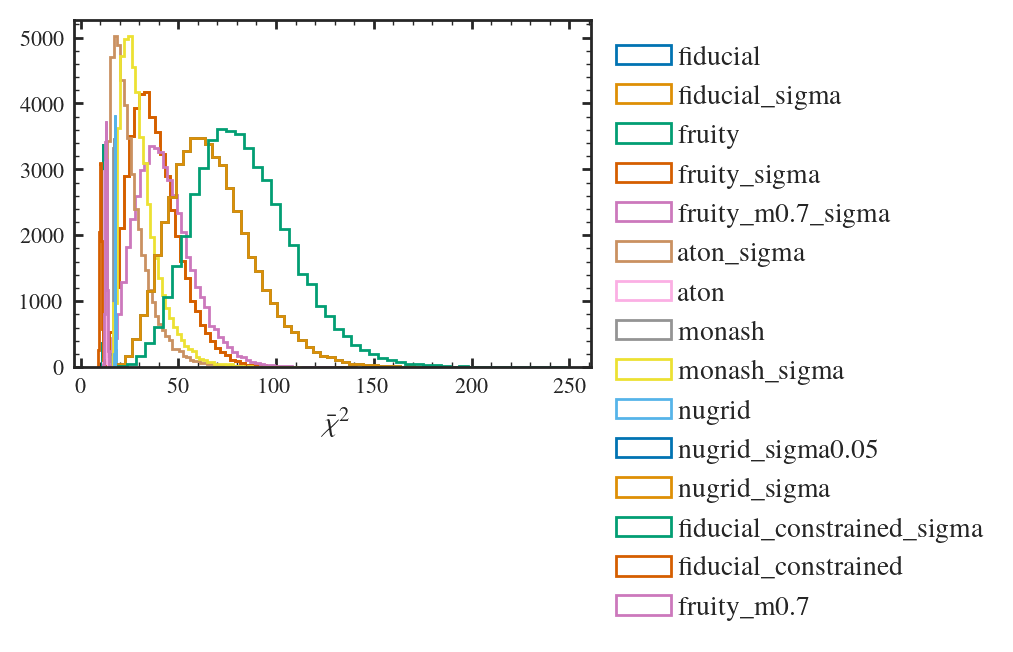

In [140]:

for label, result in results.items():
    χ2 = calc_χ2(result, median=False, normalized=True)
    lp = np.quantile(result.samples.lp, 0.95)

    m = np.median(χ2)
    l, u= np.quantile(χ2, [0.16, 0.84])

    χ2_median = calc_χ2(result, median=True, normalized=True)
    
    print(f"{label:16}{χ2_median:8.2f} {m:8.2f} -{m-l:8.2f} +{u-m:8.2f}")

    plt.hist(χ2, label=label, histtype="step")

plt.xlabel(r"$\bar\chi^2$")
arya.Legend(-1)

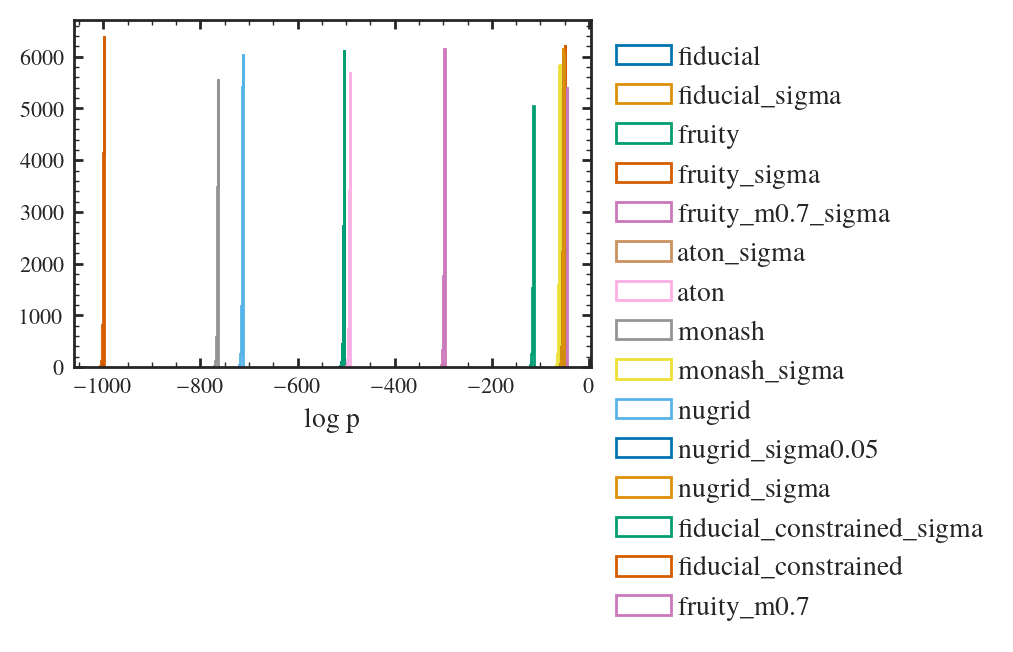

In [141]:

for label, result in results.items():
    plt.hist(result.samples.lp, label=label, histtype="step")

plt.xlabel(r"log p")
arya.Legend(-1)

In [202]:
ana = results["analytic"]

In [203]:
ana.samples.columns

Index(['iteration', 'chain', 'y0_cc', 'A_cc', 'alpha', 'zeta_cc', 'sigma_int',
       'lp', 'n_steps', 'is_accept', 'acceptance_rate', 'log_density',
       'hamiltonian_energy', 'hamiltonian_energy_error',
       'max_hamiltonian_energy_error', 'tree_depth', 'numerical_error',
       'step_size', 'nom_step_size', 'f_agb', 'y_tot', 'f_agb_a', 'y_tot_a',
       'zeta1_a'],
      dtype='object')

In [204]:
ana.samples[["zeta_cc", "zeta1_a"]].median()

zeta_cc    1.432152
zeta1_a    0.001967
dtype: float64

In [205]:
results["fruity"].samples[["zeta_cc", "zeta1_a"]].median()

zeta_cc    2.276131
zeta1_a    0.001433
dtype: float64

In [206]:
labels = {
    "fruity": r"\fruity",
    "aton": r"\aton",
    "monash": r"\monash",
    "nugrid": r"\nugrid",
    "fruity_m0.7": r"\fruity\ m0.7",
    "fruity_lin": r"\fruity\ linear",
    "eta2": r"$y\rightarrow 2y$",
    "lateburst": r"lateburst",
    "twoinfall": r"twoinfall",
    "snia_1.2": r"SN Ia 1.2",
}

In [207]:
keys = ana.labels + ["sigma_int", "f_agb_a", "y_tot_a", "zeta1_a"]
latex_table = ""

print(f"{'model':16} & $\\chi2$  & $\\log p$ & " + " & ".join(keys) + r"\\")
print("\\hline\\\\")

for key, label in labels.items():
    result = results[key]
    χ2 = calc_χ2(result, median=True, normalized=True)
    lp = np.max(result.samples.lp)

    
    # Add the row for χ2 and lp
    latex_table += f"{label:16} & {χ2:8.1f} & {lp:8.2f} & "

    # Extract parameter values and uncertainties
    parameter_lines = []
    for key in keys:
        if key not in result.samples.columns:
            parameter_lines.append(" ")
            continue
            
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]
        median = np.median(x)
        lower, upper = np.quantile(x, [0.16, 0.84])
        uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
        formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
        parameter_lines.append(f"{formatted_value}")
        
    latex_table += "  &  ".join(parameter_lines)
    latex_table += "\\\\ \n"

print(latex_table)

model            & $\chi2$  & $\log p$ & alpha & y0_cc & zeta_cc & A_cc & sigma_int & f_agb_a & y_tot_a & zeta1_a\\
\hline\\
\fruity          &      7.4 &    18.43 & $2.41^{+0.26}_{-0.27}$  &  $1.90^{+0.10}_{-0.09}$  &  $2.28^{+0.15}_{-0.16}$  &  $2.59^{+0.30}_{-0.30}$  &  $0.08^{+0.02}_{-0.01}$  &  $0.32^{+0.03}_{-0.04}$  &  $2.79^{+0.02}_{-0.02}$  &  $1.43^{+0.12}_{-0.13}$\\ 
\aton            &     14.9 &     5.30 & $1.71^{+0.34}_{-0.34}$  &  $2.55^{+0.05}_{-0.05}$  &  $3.19^{+0.40}_{-0.40}$  &  $1.92^{+0.45}_{-0.44}$  &  $0.14^{+0.03}_{-0.02}$  &  $0.06^{+0.01}_{-0.01}$  &  $2.72^{+0.03}_{-0.03}$  &  $1.48^{+0.20}_{-0.19}$\\ 
\monash          &     15.4 &     2.24 & $2.06^{+0.52}_{-0.54}$  &  $2.03^{+0.19}_{-0.18}$  &  $3.82^{+0.64}_{-0.66}$  &  $3.48^{+0.57}_{-0.59}$  &  $0.15^{+0.03}_{-0.02}$  &  $0.19^{+0.05}_{-0.05}$  &  $2.50^{+0.07}_{-0.07}$  &  $1.55^{+0.21}_{-0.22}$\\ 
\nugrid          &      5.8 &    24.19 & $1.21^{+0.11}_{-0.11}$  &  $1.58^{+0.11}_{-0.11}$  &  $1.58^{+0.11

In [99]:
# Total uncertanties
keys = ana.labels + ["sigma_int", "f_agb_a", "y_tot_a", "zeta1_a"]
latex_table = "total & & "

for key in keys:
    xs = np.array([])
    for label, result in results.items():
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]

        xs = np.concat([x, xs])
        
    median = np.median(xs)
    lower, upper = np.quantile(xs, [0.16, 0.84])
    uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
    formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
    latex_table += "  &  " + formatted_value

print(latex_table)

KeyError: 'A_cc'

In [ ]:
import weighted

In [ ]:
# weighted uncertanties
latex_table = "total & & "

for key in keys:
    xs = np.array([])
    ws = np.array([])
    for label, result in results.items():
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]

        xs = np.concat([xs, x])
        ws = np.concat([ws, result.samples.lp])

        if key == "alpha":
            print(np.sum(result.samples.lp / np.log(10) > -2))

    ws = np.exp(ws)
    ws /= np.sum(ws)
    median = weighted.median(xs, ws)
    lower, upper = [weighted.quantile(xs, ws, q) for q in [0.16, 0.84]]
    uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
    formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
    latex_table += "  &  " + formatted_value
    print(key, np.sum(xs * ws) / np.sum(ws))

print(latex_table)

In [ ]:
res = results["fiducial"].samples
plt.scatter(res.alpha, res.lp)

In [ ]:
plt.hist(np.log10(ws))